In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Preparation and Exploration

In [2]:
data = pd.read_csv('exchange_rate.csv')
data

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [3]:
data.shape

(7588, 2)

In [4]:
data.columns

Index(['date', 'Ex_rate'], dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [6]:
data.describe(include='all')

,date,Ex_rate
count,7588,7588.000000
unique,7588,NaN
top,10-10-2010 00:00,NaN
freq,1,NaN
mean,NaN,0.776974
std,NaN,0.136620
min,NaN,0.483297
25%,NaN,0.701422
50%,NaN,0.761377
75%,NaN,0.873477


In [7]:
data.nunique()

date       7588
Ex_rate    5330
dtype: int64

##### Initial Exploration

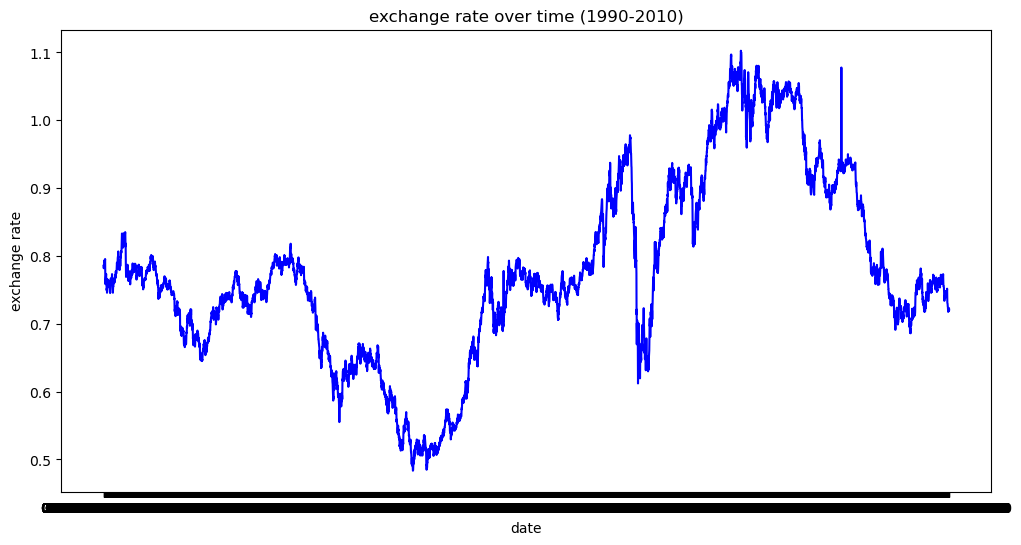

In [8]:
plt.figure(figsize=(12,6))
plt.plot(data['date'],data['Ex_rate'],color='blue')
plt.title('exchange rate over time (1990-2010)')
plt.xlabel('date')
plt.ylabel('exchange rate')
plt.show()

##### Data Preprocessing: 

In [9]:
data.isna().sum()

date       0
Ex_rate    0
dtype: int64

In [10]:
data.duplicated().sum()

np.int64(0)

In [11]:
# outliers

Q1 = data['Ex_rate'].quantile(0.25)
Q3 = data['Ex_rate'].quantile(0.75)
IQR = Q3 - Q1
lower,upper  = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

data = data[(data['Ex_rate'] >= lower) & (data['Ex_rate'] <= upper)]

#### Model Building - ARIMA

##### Parameter Selection for ARIMA

In [14]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

In [15]:
# putting date as index

data.set_index('date',inplace=True)
data

,Ex_rate
date,
01-01-1990 00:00,0.785500
02-01-1990 00:00,0.781800
03-01-1990 00:00,0.786700
04-01-1990 00:00,0.786000
05-01-1990 00:00,0.784900
...,...
06-10-2010 00:00,0.718494
07-10-2010 00:00,0.721839
08-10-2010 00:00,0.723197


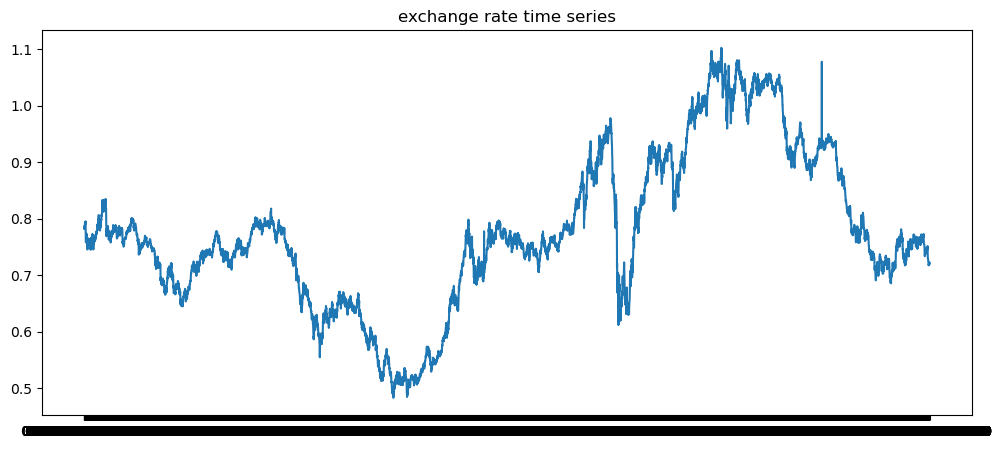

In [16]:
#plot original series
plt.figure(figsize=(12,5))
plt.plot(data['Ex_rate'])
plt.title('exchange rate time series')
plt.show()

In [17]:
# stationarity (ADF test)

result = adfuller(data['Ex_rate'])
print(f'ADF statistic :{result[0]}')
print(f'P-value: {result[1]}')

ADF statistic :-1.6649941807381343
P-value: 0.44923273535979974


In [18]:
# if P-value > 0.05, difference the series
data_diff = data['Ex_rate'].diff().dropna()

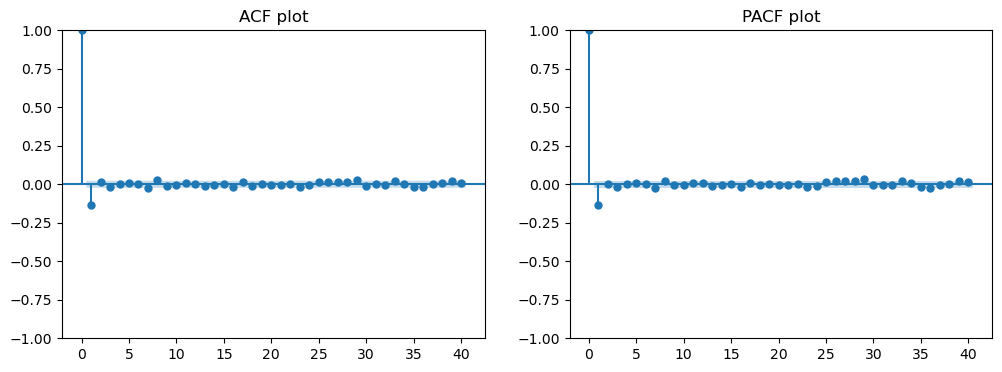

In [19]:
# plot ACF and PACF

fig,ax = plt.subplots(1,2,figsize=(12,4))
plot_acf(data_diff,ax=ax[0],lags=40)
plot_pacf(data_diff,ax=ax[1],lags=40)
ax[0].set_title('ACF plot')
ax[1].set_title('PACF plot')
plt.show()

##### Model Fitting

In [20]:
from statsmodels.tsa.arima.model import ARIMA

In [21]:
# fit the ARIMA model
model = ARIMA(data['Ex_rate'],order=(1,1,1)) #p,q,r
model_fit = model.fit()

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [22]:
# summary of the model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Thu, 06 Nov 2025   AIC                         -56102.322
Time:                        22:52:45   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.000    3.58e-05    3.62e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2865078.33
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        98.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### Diagnostics

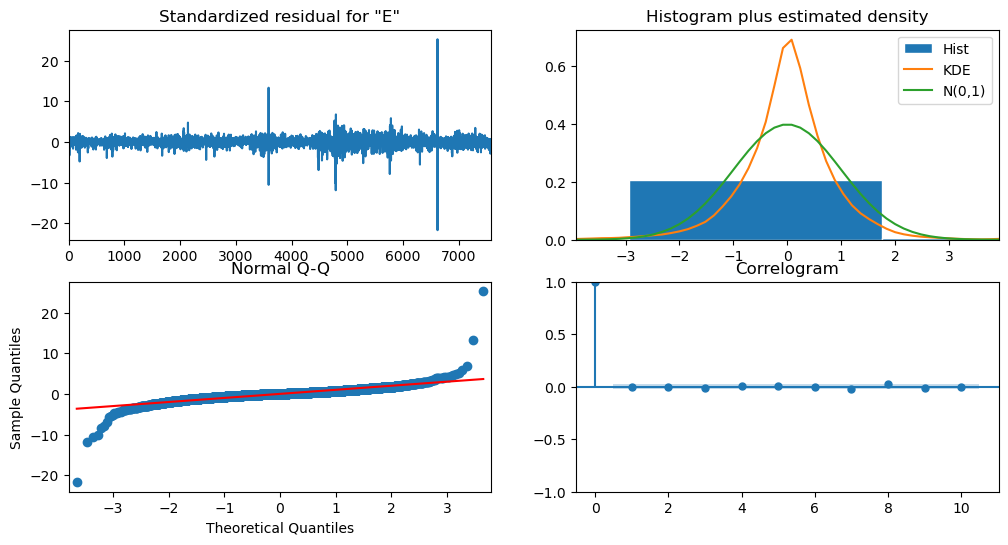

In [23]:
model_fit.plot_diagnostics(figsize=(12,6))
plt.show()

##### Forecasting

In [24]:
# split data into train and test
train = data.iloc[:-100]
test = data.iloc[-100:]

In [25]:
# fit model on train data
model = ARIMA(train['Ex_rate'],order=(1,1,1))
model_fit = model.fit()

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [26]:
#forecast for test period
forecast = model_fit.forecast(steps=100)

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


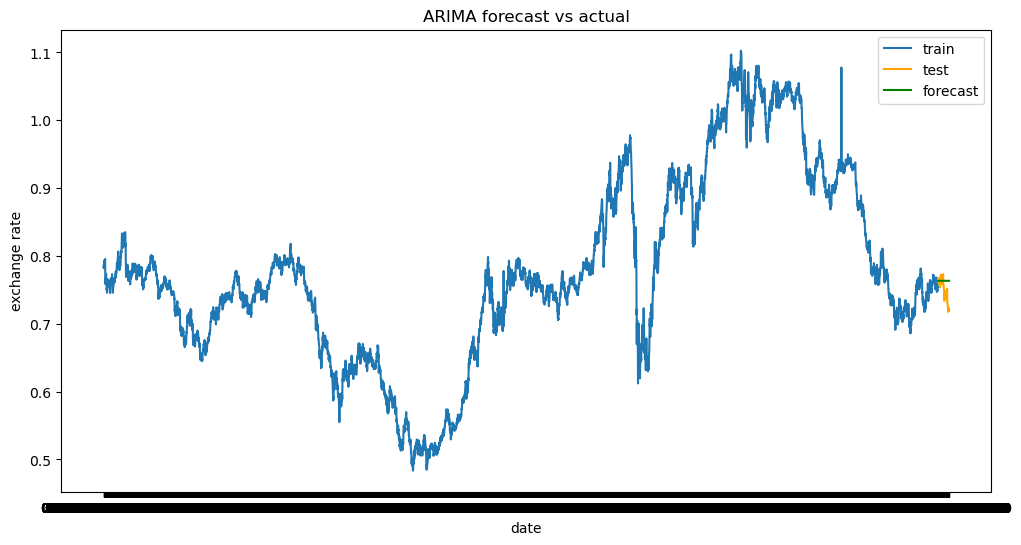

In [27]:
#plot result
plt.figure(figsize=(12,6))
plt.plot(train.index,train['Ex_rate'],label='train')
plt.plot(test.index,test['Ex_rate'],label='test',color='orange')
plt.plot(test.index,forecast,label='forecast',color='green')
plt.title('ARIMA forecast vs actual')
plt.xlabel('date')
plt.ylabel('exchange rate')
plt.legend()
plt.show()

#### Model Building - Exponential Smoothing

In [28]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,ExponentialSmoothing

In [29]:
#simple exponential smmoothig

ses_model = SimpleExpSmoothing(train['Ex_rate']).fit()
ses_forecast = ses_model.forecast(steps=100)

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [30]:
#Holt's Linear

holt_model = ExponentialSmoothing(
    train['Ex_rate'],
    trend='add',
    seasonal=None,
    initialization_method='estimated'
).fit()

holt_forecast = holt_model.forecast(steps=100)

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [31]:
# holt-winters

hw_model = ExponentialSmoothing(
    train['Ex_rate'],
    trend='add',
    seasonal='add',
    seasonal_periods=365,
    initialization_method='estimated'
).fit()

hw_forecast = hw_model.forecast(steps=100)

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


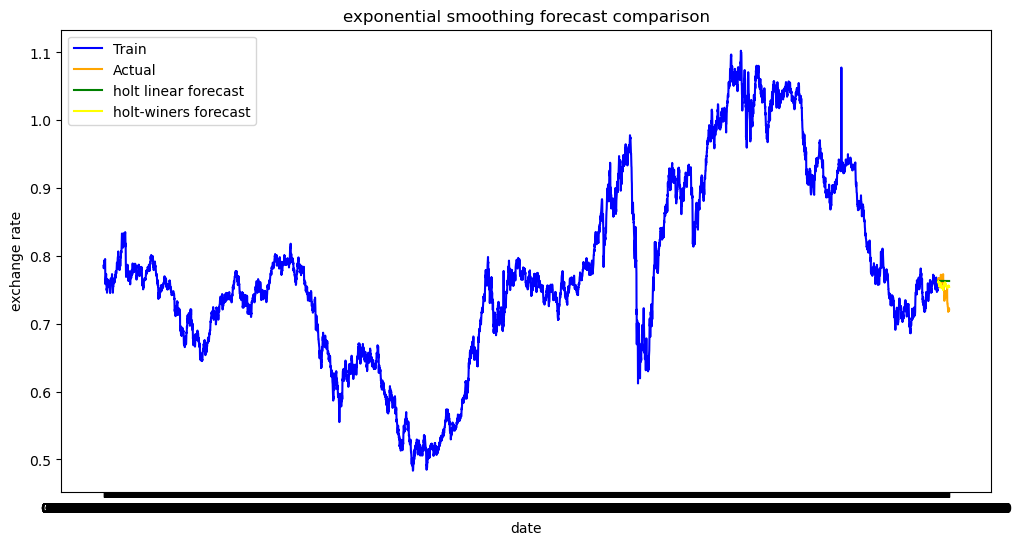

In [32]:
#compare forecast vs actual

plt.figure(figsize=(12,6))
plt.plot(train.index,train['Ex_rate'],label='Train',color='blue')
plt.plot(test.index,test['Ex_rate'],label='Actual',color='orange')

plt.plot(test.index,holt_forecast,label='holt linear forecast',color='green')
plt.plot(test.index,hw_forecast,label='holt-winers forecast',color='yellow')

plt.title('exponential smoothing forecast comparison')
plt.xlabel('date')
plt.ylabel('exchange rate')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error

In [34]:
# evaluate forecast accuracy

rmse_holt = np.sqrt(mean_squared_error(test['Ex_rate'],holt_forecast))
rmse_hw = np.sqrt(mean_squared_error(test['Ex_rate'],hw_forecast))

print(f'holt linear rmse : {rmse_holt:.3}')
print(f'holt winters rmse : {rmse_hw:.3}')

holt linear rmse : 0.0204
holt winters rmse : 0.017


#### Evaluation and Comparison

In [35]:
from sklearn.metrics import mean_absolute_error

In [36]:
def safe_map(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    mask = y_true != 0 
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [37]:
def evaluate_model(test,preds_dicts):
    results = {}
    for name,forecast in preds_dicts.items():
        mae = mean_absolute_error(test,forecast)
        rmse = np.sqrt(mean_squared_error(test,forecast)) 
        mape = safe_map(test,forecast)
        results[name] = [mae,rmse,mape]
        
    print(f"{'model' :<15}{'mae':>12}{'rmse':<12}{'mape (%)':<12}")
    print('-'*50) 
    for model,vals in results.items(): 
        print(f'{model:<15}{vals[0]:<12.3f}{vals[1]:12.3f}{vals[2]:12.2f}')
        

In [38]:
preds = {
    'ARIMA': forecast,
    'HOlt_Linear': holt_forecast,
    'Holt_winters': hw_forecast
}

In [39]:
evaluate_model(test['Ex_rate'],preds)

model                   maermse        mape (%)    
--------------------------------------------------
ARIMA          0.015              0.021        2.04
HOlt_Linear    0.015              0.020        2.02
Holt_winters   0.013              0.017        1.80


##### Model Comparison

###### ARIMA :
###### captures autocorrelation and trends well. performs best when short term fluctyations matter, slightly more comples and requried sationary data
###### Holts Linear :
###### simple,fast,adapts to trens. work well for smooth series bur may miss rapid changes
###### Holt-Winters :
###### handles trend + seasonality. best if strong seasonal patterns exist, otherwise may overfit

###### observations :
###### RMSE and MAPE indicate ARIMA and Holt-Winters perform Slightly better than Holt Linear.
###### if the series has minimal seasonality, simpler models(hot linear) are nearly as effective

##### Conclusion

###### ARIMA  is recommeded for datasets with autocorrelation and subtle fluctuations
###### Holts Linear is a strong, simple alterative for trend - dominant series
###### Holt-Winters excels if clear seasonal patterns exist
###### overall, ARIMA or Holts-Winters yielded the best forecast accuracy for this exchange rate dataset